LSTM Model for MSL Forecasting with Spatial-Temporal Data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [4]:
# Load the netCDF4 data
ds = xr.open_dataset(r'D:\first_project_smart_meteorology\my_data\ERA5_1.nc')


In [5]:
# Convert valid_time to datetime
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values, unit='s')

In [6]:
# Extract mean sea level pressure data
msl = ds['msl'].values

In [7]:
# Reshape the data: (time, lat, lon) -> (time, lat*lon)
msl_reshaped = msl.reshape(msl.shape[0], -1)

In [8]:
# Create a DataFrame
df = pd.DataFrame(msl_reshaped, index=ds['valid_time'].values)

In [9]:
# Normalize the data
scaler = MinMaxScaler()
msl_normalized = scaler.fit_transform(df)

In [10]:

# Create sequences for forecasting
def create_sequences(data, input_seq_length, output_seq_length):
    X, y = [], []
    for i in range(len(data) - input_seq_length - output_seq_length + 1):
        X.append(data[i:(i + input_seq_length)])
        y.append(data[(i + input_seq_length):(i + input_seq_length + output_seq_length)])
    return np.array(X), np.array(y)

input_seq_length = 24  # Use 24 time steps as input
output_seq_length = 6  # Predict 6 time steps ahead
X, y = create_sequences(msl_normalized, input_seq_length, output_seq_length)

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)


(111, 28, 111, 28)

In [36]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# Build the LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(input_seq_length, msl_reshaped.shape[1])),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(msl_reshaped.shape[1]* output_seq_length)
])

model.compile(optimizer='adam', loss='mse')

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 24, 128)           22809600  
                                                                 
 batch_normalization_4 (Batc  (None, 24, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 64)            49408     
                                                                 
 batch_normalization_5 (Batc  (None, 24, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 24, 64)           

In [38]:
# Train the model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1), 
                    epochs=50, batch_size=32,  validation_split=0.2, verbose=1)

Epoch 1/50
3/3 [==============================] - 48s 16s/step - loss: 0.3555 - val_loss: 8.4555
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 0.3531 - val_loss: 0.4651
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 0.3507 - val_loss: 0.4618
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 0.3478 - val_loss: 0.5837
Epoch 5/50
3/3 [==============================] - 5s 2s/step - loss: 0.3449 - val_loss: 0.3545
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 0.3414 - val_loss: 0.3485
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 0.3376 - val_loss: 0.3412
Epoch 8/50
3/3 [==============================] - 5s 2s/step - loss: 0.3353 - val_loss: 0.3349
Epoch 9/50
3/3 [==============================] - 5s 2s/step - loss: 0.3336 - val_loss: 0.3280
Epoch 10/50
3/3 [==============================] - 5s 2s/step - loss: 0.3264 - val_loss: 0.3040
Epoch 11/50
3/3 [==============================

In [39]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train.reshape(y_train.shape[0], -1), verbose=0)
test_loss = model.evaluate(X_test, y_test.reshape(y_test.shape[0], -1), verbose=0)
print(f'Train MSE: {train_loss:.4f}')
print(f'Test MSE: {test_loss:.4f}')

Train MSE: 0.0580
Test MSE: 0.0610


In [40]:
# Make forecasts
forecasts = model.predict(X_test)
forecasts = forecasts.reshape(forecasts.shape[0], output_seq_length, -1)

1/1 [==============================] - 2s 2s/step


In [41]:
# Inverse transform the forecasts and actual values
forecasts = scaler.inverse_transform(forecasts.reshape(-1, msl_reshaped.shape[1])).reshape(forecasts.shape)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, msl_reshaped.shape[1])).reshape(y_test.shape)

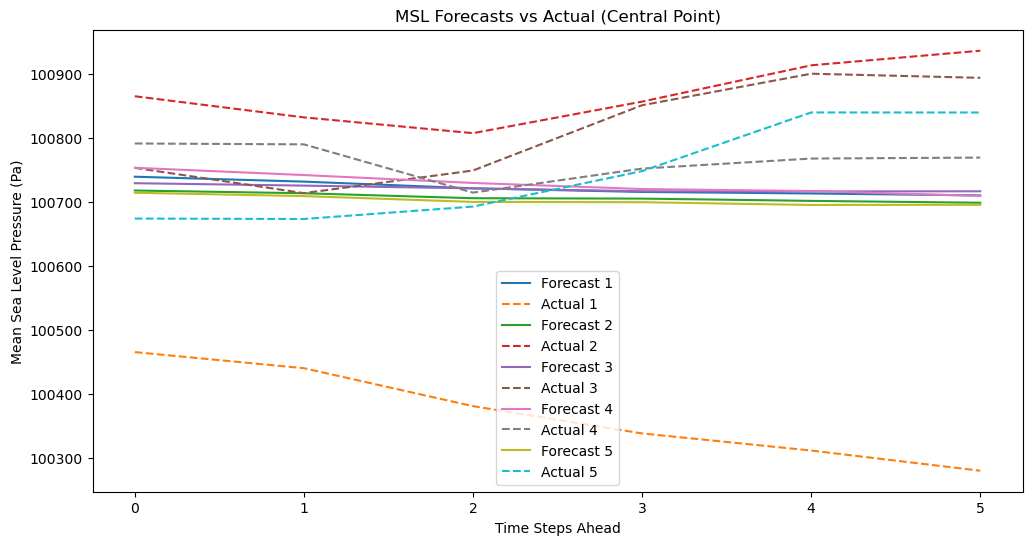

In [43]:
# Plot forecasts for a single point (e.g., central point)
central_point = msl_reshaped.shape[1] // 2
plt.figure(figsize=(12, 6))
for i in range(5):  # Plot first 5 forecasts
    plt.plot(range(output_seq_length), forecasts[i, :, central_point], label=f'Forecast {i+1}')
    plt.plot(range(output_seq_length), y_test_actual[i, :, central_point], label=f'Actual {i+1}', linestyle='--')
plt.title('MSL Forecasts vs Actual (Central Point)')
plt.xlabel('Time Steps Ahead')
plt.ylabel('Mean Sea Level Pressure (Pa)')
plt.legend()
plt.show()

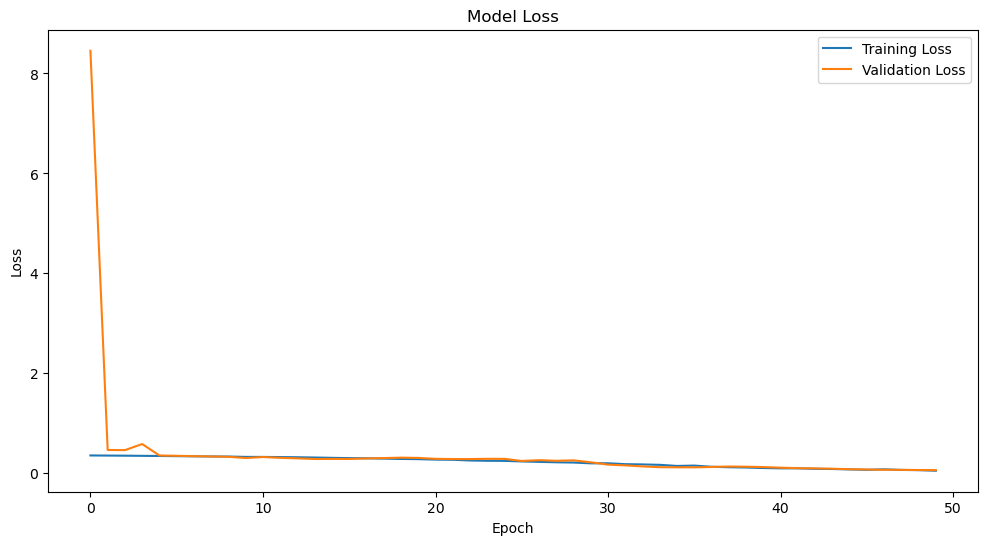

In [44]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# Function to create a forecast beyond known data
def create_forecast(model, last_known_sequence, num_steps):
    forecast = []
    current_sequence = last_known_sequence.copy()
    
    for _ in range(num_steps):
        next_step = model.predict(current_sequence.reshape(1, input_seq_length, -1))
        next_step = next_step.reshape(output_seq_length, -1)
        forecast.append(next_step[0])
        current_sequence = np.vstack((current_sequence[1:], next_step[0]))
    
    return np.array(forecast)

In [46]:
# Create a forecast for 24 steps beyond the last known data
last_sequence = msl_normalized[-input_seq_length:]
future_forecast = create_forecast(model, last_sequence, 24)

1/1 [==============================] - 0s 184ms/step


In [47]:
# Inverse transform the future forecast
future_forecast = scaler.inverse_transform(future_forecast)

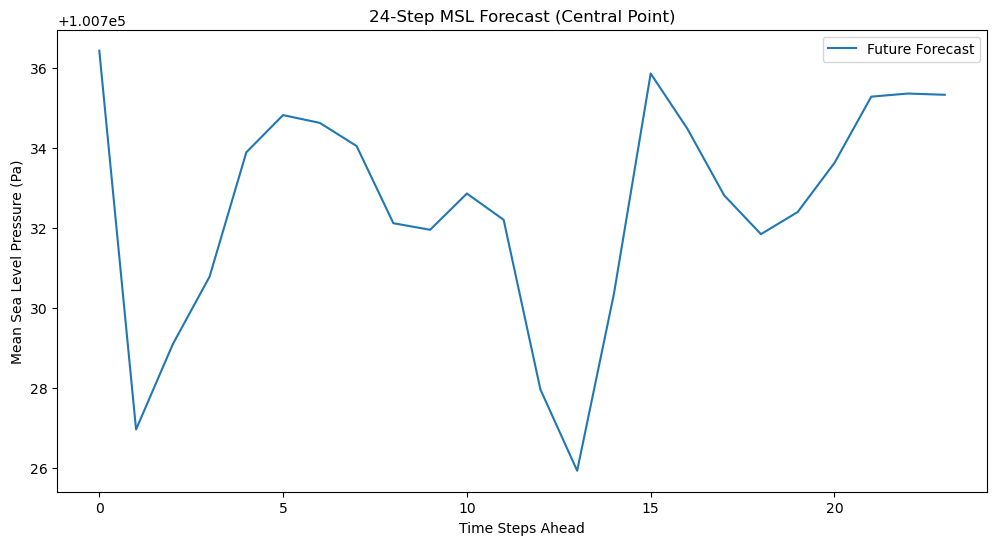

In [48]:
# Plot the future forecast for the central point
plt.figure(figsize=(12, 6))
plt.plot(range(24), future_forecast[:, central_point], label='Future Forecast')
plt.title('24-Step MSL Forecast (Central Point)')
plt.xlabel('Time Steps Ahead')
plt.ylabel('Mean Sea Level Pressure (Pa)')
plt.legend()
plt.show()

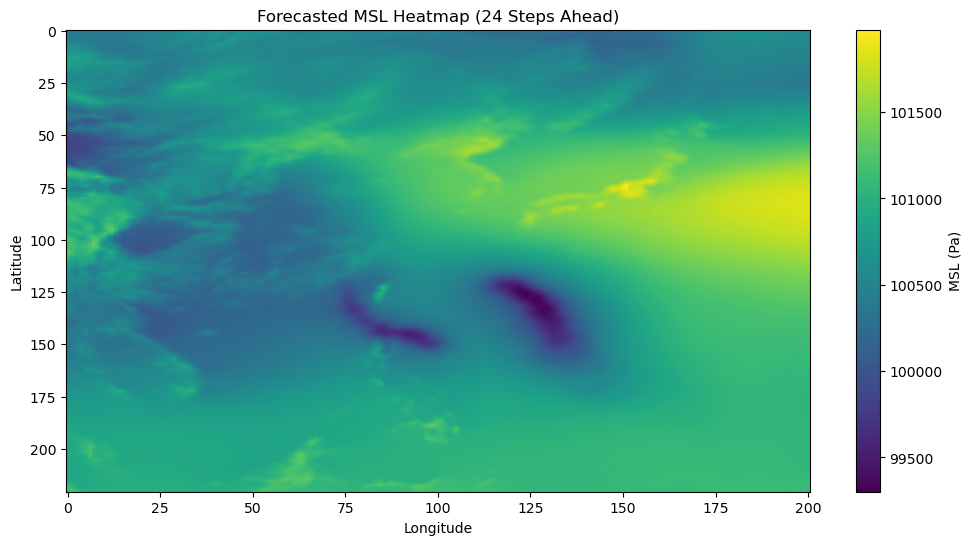

In [49]:
# Plot a heatmap of the forecasted MSL for the last time step
plt.figure(figsize=(12, 6))
plt.imshow(future_forecast[-1].reshape(221, 201), cmap='viridis', aspect='auto')
plt.colorbar(label='MSL (Pa)')
plt.title('Forecasted MSL Heatmap (24 Steps Ahead)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()